In [10]:
%load_ext autoreload
%autoreload 2

import time
import logging
import numpy as np
import matplotlib.pyplot as plt

import cflib.crtp
from cflib.positioning.position_hl_commander import PositionHlCommander
from cflib.utils.multiranger import Multiranger

from cfpilot.controller import CrazyflieController
from path_planning import get_waypoints, create_test_environment
from path_planning import plan_path, simplify_path, visualize_path
import math
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("✅ Imports complete")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Imports complete


# Waypoint Following Test Flight

This notebook tests the complete path planning and waypoint following system:
1. Create grid map with obstacles
2. Plan path using D* Lite
3. Simplify path to remove unnecessary waypoints
4. Follow waypoints with Crazyflie
5. Land at goal position

# Dynamic Obstacle Detection and Replanning

This cell demonstrates:
1. Start with initial planned path (static obstacles)
2. During flight, detect obstacles using multiranger
3. Update grid map with detected obstacles
4. Replan path when obstacles block the way


Initializing
Path found
Initializing
Path found


<Figure size 1400x800 with 0 Axes>

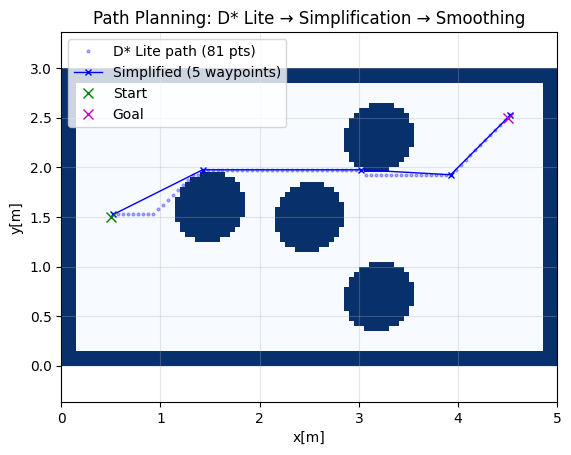

✅ Initial path planned with 5 waypoints


In [11]:
# Import new functions
from path_planning import (
    update_obstacles_from_multiranger, 
    is_path_clear, 
    dynamic_replan,
    check_obstacle_proximity
)

# Create empty grid map (no obstacles initially - will be detected by multiranger)
grid_map = create_test_environment(width=5.0, height=3.0)
grid_map.occupy_boundaries(boundary_width=2)

# Initial path planning
start = (0.5, 1.5)
goal = (4.5, 2.5)

# Plan initial path (will update during flight)
path_found, pathx, pathy = plan_path(grid_map, start, goal)
pathx_simp, pathy_simp = simplify_path(pathx, pathy, grid_map)
pos_x, pos_y = grid_map.get_xy_poss_from_xy_indexes(pathx_simp, pathy_simp)


visualize_path(grid_map, start_pos=start, goal_pos=goal, show_smooth=False);
print(f"✅ Initial path planned with {len(pos_x)} waypoints")


In [ ]:
from path_planning import ObstacleAvoidanceController

try:
    mission_time = 60.0  # seconds
    start_time = time.time()
    
    # Setup position commander
    pc = PositionHlCommander(
        crazyflie=controller.cf,
        x=start[0],
        y=start[1],
        z=0.1,
        default_velocity=0.2,
        default_height=0.5,
        controller=2
    )
    
    # Initialize obstacle avoidance controller
    oa_controller = ObstacleAvoidanceController(
        grid_map=grid_map,
        multiranger=multiranger,
        replan_threshold=0.8,      # Trigger replanning at 0.8m
        danger_threshold=0.5,      # Reactive avoidance at 0.5m
        update_frequency=5         # Update map every 5 iterations
    )
    logger.info("✅ Obstacle avoidance controller initialized")
    
    # Takeoff
    logger.info("🚁 Taking off...")
    height = 0.5
    pc.take_off(height=height, velocity=0.5)
    time.sleep(2)  # Wait for stable takeoff

    # Waypoint following WITH obstacle avoidance
    logger.info(f"🗺️ Following {len(pos_x)} waypoints with obstacle avoidance...")
    current_idx = 0
    stuck_counter = 0
    max_stuck = 30  # 3 seconds at 10Hz
    
    while current_idx < len(pos_x) and time.time() - start_time < mission_time:
        # Get current state
        latest = controller.get_latest_data()
        current_x = latest.get('stateEstimate.x', 0)
        current_y = latest.get('stateEstimate.y', 0)
        current_z = latest.get('stateEstimate.z', 0)
        current_yaw = np.radians(latest.get('stabilizer.yaw', 0))
        
        # Current target waypoint
        target_x = pos_x[current_idx]
        target_y = pos_y[current_idx]
        
        # Update obstacle avoidance controller
        result = oa_controller.update(
            current_x=current_x,
            current_y=current_y,
            current_yaw=current_yaw,
            target_x=target_x,
            target_y=target_y,
            goal_x=goal[0],
            goal_y=goal[1],
            waypoints_x=pos_x,
            waypoints_y=pos_y,
            current_waypoint_idx=current_idx
        )
        
        # Handle emergency stop
        if result['emergency_stop']:
            logger.warning("? EMERGENCY STOP - Obstacle too close!")
            pc.go_to(current_x, current_y, height, velocity=0.0)
            time.sleep(0.5)
            stuck_counter += 1
            
            if stuck_counter > max_stuck:
                logger.warning("⚠️ Stuck! Forcing replan...")
                result['should_replan'] = True
                stuck_counter = 0
            continue
        
        # Handle replanning
        if result['should_replan']:
            logger.info("🔄 Path blocked - Replanning...")
            pos_x = result['new_waypoints_x']
            pos_y = result['new_waypoints_y']
            current_idx = 0
            stuck_counter = 0
            logger.info(f"   New path: {len(pos_x)} waypoints")
            continue
        
        # Calculate safe velocity
        safe_velocity = oa_controller.get_safe_velocity()
        
        # Execute movement
        if result['avoidance_active']:
            # Use adjusted target for avoidance
            cmd_x = result['adjusted_target_x']
            cmd_y = result['adjusted_target_y']
            logger.debug(f"⚠️ Avoiding: target ({cmd_x:.2f}, {cmd_y:.2f})")
        else:
            # Normal waypoint following
            cmd_x = target_x
            cmd_y = target_y
        
        pc.go_to(cmd_x, cmd_y, height, velocity=safe_velocity)
        
        # Check if reached waypoint
        distance = np.hypot(current_x - target_x, current_y - target_y)
        if distance < 0.15:
            logger.info(f"✅ Waypoint {current_idx + 1}/{len(pos_x)} reached")
            current_idx += 1
            stuck_counter = 0
        
        time.sleep(0.1)  # 10 Hz control loop
    
    if current_idx >= len(pos_x):
        logger.info("? All waypoints reached!")
    else:
        logger.warning("⏰ Mission timeout")
    
    # Land
    logger.info("🛬 Landing...")
    pc.land()
    
    # Monitor landing
    current_time = time.time()
    while time.time() - current_time < 3:
        latest = controller.get_latest_data()
        logger.info(f"📍 Landing: ({latest.get('stateEstimate.x', 0):.2f}, "
                   f"{latest.get('stateEstimate.y', 0):.2f}, {latest.get('stateEstimate.z', 0):.2f})")
        time.sleep(0.5) 
    
    # Stop multiranger
    multiranger.stop()
    controller.save_flight_data()
    logger.info("✅ Mission complete!")
    
except Exception as e:
    logger.error(f"❌ Error during flight: {e}")
    import traceback
    traceback.print_exc()
    try:
        pc.land()
    except:
        pass
    controller.emergency_shutdown()
    raise
finally:
    controller.cleanup()
    controller.disconnect()

2025-10-06 17:43:45,927 - cfpilot.detection - INFO - Landing pad detector initialized
2025-10-06 17:43:45,927 - cfpilot.controller - INFO - Crazyflie Controller initialized (Async)


✅ Drivers initialized


2025-10-06 17:43:46,428 - cfpilot.controller - INFO - Connecting to radio://0/88/2M/E7E7E7E7F0
2025-10-06 17:43:46,429 - cflib.crazyflie - INFO - Callback->Connection initialized[radio://0/88/2M/E7E7E7E7F0]
2025-10-06 17:43:46,743 - cflib.crazyflie - INFO - We are connected[radio://0/88/2M/E7E7E7E7F0], request connection setup
2025-10-06 17:43:46,744 - cflib.crazyflie.platformservice - INFO - Request _request_protocol_version()
2025-10-06 17:43:46,747 - cflib.crazyflie - INFO - Callback->Connected to [radio://0/88/2M/E7E7E7E7F0]
2025-10-06 17:43:46,804 - cflib.crazyflie.platformservice - INFO - _crt_service_callback
2025-10-06 17:43:46,805 - cflib.crazyflie.platformservice - INFO - Request protocol version
2025-10-06 17:43:46,809 - cflib.crazyflie.platformservice - INFO - _platform_callback
2025-10-06 17:43:46,809 - cflib.crazyflie.platformservice - INFO - Protocol version (platform): 10
2025-10-06 17:43:46,820 - cflib.crazyflie.toc - INFO - TOC for port [5] found in cache
2025-10-06 1

✅ Connection initiated


2025-10-06 17:43:52,588 - __main__ - ERROR - ❌ Error during flight: update_obstacles_from_multiranger() got an unexpected keyword argument 'obstacle_radius'
2025-10-06 17:43:55,089 - cfpilot.controller - WARNING - ❌ Emergency shutdown initiated
2025-10-06 17:43:55,099 - cfpilot.controller - INFO - 🛜 Flight data saved to: /home/vahid/repos/crazyflie/cfpilot/logs/flight_log_20251006_174355.csv
2025-10-06 17:43:55,100 - cfpilot.controller - INFO - Controller cleanup completed
2025-10-06 17:43:55,101 - cflib.crazyflie - INFO - Closing link
2025-10-06 17:43:56,103 - cflib.crazyflie.param - INFO - Disconnected, cleaning up threads
2025-10-06 17:43:56,104 - cflib.crazyflie - INFO - Callback->Disconnected from [radio://0/88/2M/E7E7E7E7F0]
2025-10-06 17:43:56,125 - cfpilot.controller - INFO - ❌ Disconnected from radio://0/88/2M/E7E7E7E7F0


TypeError: update_obstacles_from_multiranger() got an unexpected keyword argument 'obstacle_radius'

In [ ]:
# Visualize final grid map with detected obstacles
plt.figure(figsize=(12, 8))
grid_map.plot_grid_map(use_world_coords=True)
plt.plot(start[0], start[1], 'go', markersize=10, label='Start')
plt.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')
if len(pos_x) > 0:
    plt.plot(pos_x, pos_y, 'b.-', linewidth=2, label='Final Path')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.title('Grid Map with Detected Obstacles')
plt.legend()
plt.show()


Initializing
Path found
Initializing
Path found


<Figure size 1400x800 with 0 Axes>

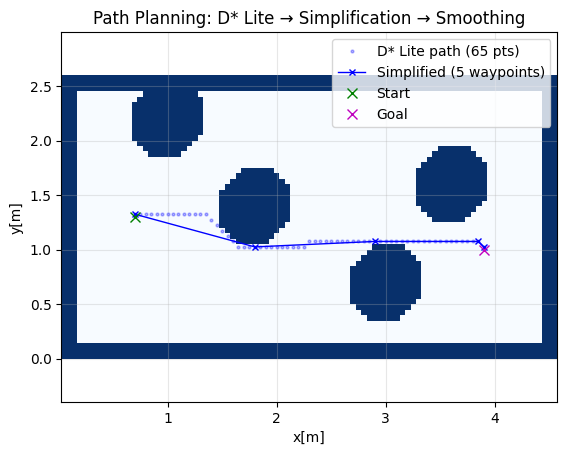

In [ ]:
grid_map = create_test_environment(width=4.7, height=3.0)
# Plan
start = (0.7, 1.3)
goal = (3.9, 1.0)
path_found, pathx, pathy = plan_path(grid_map, start, goal)

# Simplify
pathx_simp, pathy_simp = simplify_path(pathx, pathy, grid_map)

# Convert to world coords
pos_x, pos_y = grid_map.get_xy_poss_from_xy_indexes(pathx_simp, pathy_simp)

visualize_path(grid_map, start_pos=start, goal_pos=goal, show_smooth=False);

Waypoint 0: (0.7, 1.325)
Waypoint 1: (1.7999999999999998, 1.025)


In [12]:
controller = CrazyflieController(enable_plotting=False)
config = controller.config
# Initialize drivers
cflib.crtp.init_drivers()
print("✅ Drivers initialized"  )
# Connect to Crazyflie (will auto-detect or use config URI)
uri = config['connection']['uri']
time.sleep(0.5)
controller.connect(uri, x=start[0], y=start[1], z=0.1, yaw=0.0)
print("✅ Connection initiated"  )
# Wait for connection
if controller.wait_for_connection(timeout=10.0):
    logger.info("✅ Connected successfully!")
else:
    logger.error("❌ Connection failed!")
    raise Exception("Could not connect to Crazyflie")


try:
    mission_time = 10.0  # seconds - increased timeout for waypoint following
    start_time = time.time()
    
    # Setup position commander
    pc = PositionHlCommander(
        crazyflie=controller.cf,
        x=start[0],
        y=start[1],
        z=0.1,
        default_velocity=0.2,
        default_height=0.5,
        controller=2
    )
        
    # Start multiranger for obstacle detection
    multiranger = Multiranger(controller.cf)
    multiranger.start()
    logger.info("✅ Multiranger started")
    
    # Takeoff
    logger.info("🚁 Taking off...")
    height = 0.5
    pc.take_off(height=height, velocity=0.5)
    time.sleep(2)  # Wait for stable takeoff


    for i, (target_x, target_y) in enumerate(zip(pos_x[:2], pos_y[:2])):
        if time.time() - start_time > mission_time:
            logger.warning("⏰ Mission timeout reached")
            break
            
        logger.info(f"🎯 Waypoint {i+1}/{len(pos_x)}: ({target_x:.2f}, {target_y:.2f})")
        
        # Move to waypoint
        pc.go_to(target_x, target_y, height, velocity=0.3)
        
        # Wait and verify position
        time.sleep(0.5)
        latest = controller.get_latest_data()
        current_x = latest.get('stateEstimate.x', 0)
        current_y = latest.get('stateEstimate.y', 0)
        current_z = latest.get('stateEstimate.z', 0)
        
        # Calculate distance to target
        distance = ((current_x - target_x)**2 + (current_y - target_y)**2)**0.5
        
        logger.info(f"📍 Current position: ({current_x:.2f}, {current_y:.2f}, {current_z:.2f})")
        logger.info(f"📏 Distance to waypoint: {distance:.2f}m")
    
    
    # Follow waypoints
    logger.info(f"🗺️ Following {len(pos_x)} waypoints...")

    latest = controller.get_latest_data()
    current_x = latest.get('stateEstimate.x', 0)
    current_y = latest.get('stateEstimate.y', 0)
    current_z = latest.get('stateEstimate.z', 0)

    logger.info(f"📍 Current position: ({current_x:.2f}, {current_y:.2f}, {current_z:.2f})")

    logger.info("🛬 Landing...")
    pc.land()
    
    # Monitor landing
    current_time = time.time()
    while time.time() - current_time < 3:
        latest = controller.get_latest_data()
        logger.info(f"📍 Landing position: ({latest.get('stateEstimate.x', 0):.2f}, "
                   f"{latest.get('stateEstimate.y', 0):.2f}, {latest.get('stateEstimate.z', 0):.2f})")
        time.sleep(0.1) 
    
    # Stop multiranger
    multiranger.stop()
    controller.save_flight_data()
    logger.info("✅ Waypoint following complete!")
    
except Exception as e:
    logger.error(f"❌ Error during flight: {e}")
    try:
        pc.land()
    except:
        pass
    controller.emergency_shutdown()
    raise
finally:
    controller.cleanup()
    controller.disconnect()

    

2025-10-06 15:22:07,834 - cfpilot.detection - INFO - Landing pad detector initialized
2025-10-06 15:22:07,835 - cfpilot.controller - INFO - Crazyflie Controller initialized (Async)


✅ Drivers initialized


2025-10-06 15:22:08,336 - cfpilot.controller - INFO - Connecting to radio://0/88/2M/E7E7E7E7F0
2025-10-06 15:22:08,337 - cflib.crazyflie - INFO - Callback->Connection initialized[radio://0/88/2M/E7E7E7E7F0]
2025-10-06 15:22:08,648 - cflib.crazyflie - INFO - We are connected[radio://0/88/2M/E7E7E7E7F0], request connection setup
2025-10-06 15:22:08,648 - cflib.crazyflie.platformservice - INFO - Request _request_protocol_version()
2025-10-06 15:22:08,651 - cflib.crazyflie - INFO - Callback->Connected to [radio://0/88/2M/E7E7E7E7F0]
2025-10-06 15:22:08,707 - cflib.crazyflie.platformservice - INFO - _crt_service_callback
2025-10-06 15:22:08,708 - cflib.crazyflie.platformservice - INFO - Request protocol version
2025-10-06 15:22:08,711 - cflib.crazyflie.platformservice - INFO - _platform_callback
2025-10-06 15:22:08,712 - cflib.crazyflie.platformservice - INFO - Protocol version (platform): 10
2025-10-06 15:22:08,723 - cflib.crazyflie.toc - INFO - TOC for port [5] found in cache
2025-10-06 1

✅ Connection initiated


2025-10-06 15:22:14,476 - __main__ - INFO - 🎯 Waypoint 1/5: (0.70, 1.32)
2025-10-06 15:22:15,061 - __main__ - INFO - 📍 Current position: (0.70, 1.34, 0.52)
2025-10-06 15:22:15,061 - __main__ - INFO - 📏 Distance to waypoint: 0.01m
2025-10-06 15:22:15,062 - __main__ - INFO - 🎯 Waypoint 2/5: (1.80, 1.02)
2025-10-06 15:22:19,363 - __main__ - INFO - 📍 Current position: (1.84, 1.00, 0.52)
2025-10-06 15:22:19,364 - __main__ - INFO - 📏 Distance to waypoint: 0.04m
2025-10-06 15:22:19,364 - __main__ - INFO - 🗺️ Following 5 waypoints...
2025-10-06 15:22:19,364 - __main__ - INFO - 📍 Current position: (1.84, 1.00, 0.52)
2025-10-06 15:22:19,365 - __main__ - INFO - 🛬 Landing...
2025-10-06 15:22:21,865 - __main__ - INFO - 📍 Landing position: (1.80, 1.02, 0.04)
2025-10-06 15:22:21,966 - __main__ - INFO - 📍 Landing position: (1.80, 1.02, 0.02)
2025-10-06 15:22:22,066 - __main__ - INFO - 📍 Landing position: (1.80, 1.03, 0.02)
2025-10-06 15:22:22,167 - __main__ - INFO - 📍 Landing position: (1.79, 1.04, 0.

In [ ]:
controller = CrazyflieController(enable_plotting=False)
config = controller.config
# Initialize drivers
cflib.crtp.init_drivers()

# Connect to Crazyflie (will auto-detect or use config URI)
uri = config['connection']['uri']
controller.connect(uri)

# Wait for connection
if controller.wait_for_connection(timeout=10.0):
    logger.info("✅ Connected successfully!")
else:
    logger.error("❌ Connection failed!")
    raise Exception("Could not connect to Crazyflie")

try:
    mission_time = 60.0  # seconds - increased timeout for waypoint following
    start_time = time.time()
    
    # Setup position commander
    pc = PositionHlCommander(
        crazyflie=controller.cf,
        x=start[0],
        y=start[1],
        z=0.1,
        default_velocity=0.2,
        default_height=0.5,
        controller=2
    )
    
    # Start multiranger for obstacle detection
    multiranger = Multiranger(controller.cf)
    multiranger.start()
    logger.info("✅ Multiranger started")
    
    # Takeoff
    logger.info("🚁 Taking off...")
    height = 0.5
    pc.take_off(height=height, velocity=0.5)
    time.sleep(2)  # Wait for stable takeoff

    # Follow waypoints
    logger.info(f"🗺️ Following {len(pos_x)} waypoints...")
    
    for i, (target_x, target_y) in enumerate(zip(pos_x, pos_y)):
        if time.time() - start_time > mission_time:
            logger.warning("⏰ Mission timeout reached")
            break
            
        logger.info(f"🎯 Waypoint {i+1}/{len(pos_x)}: ({target_x:.2f}, {target_y:.2f})")
        
        # Move to waypoint
        pc.go_to(target_x, target_y, height, velocity=0.3)
        
        # Wait and verify position
        time.sleep(0.5)
        latest = controller.get_latest_data()
        current_x = latest.get('stateEstimate.x', 0)
        current_y = latest.get('stateEstimate.y', 0)
        current_z = latest.get('stateEstimate.z', 0)
        
        # Calculate distance to target
        distance = ((current_x - target_x)**2 + (current_y - target_y)**2)**0.5
        
        logger.info(f"📍 Current position: ({current_x:.2f}, {current_y:.2f}, {current_z:.2f})")
        logger.info(f"📏 Distance to waypoint: {distance:.2f}m")
        
        # Fine adjustment if needed
        max_attempts = 1
        attempt = 0
        while distance > 0.2 and attempt < max_attempts and time.time() - start_time < mission_time:
            logger.info(f"🔧 Fine adjustment attempt {attempt+1}")
            pc.go_to(target_x, target_y, height, velocity=0.1)
            time.sleep(0.5)
            
            latest = controller.get_latest_data()
            current_x = latest.get('stateEstimate.x', 0)
            current_y = latest.get('stateEstimate.y', 0)
            distance = ((current_x - target_x)**2 + (current_y - target_y)**2)**0.5
            attempt += 1
        
        logger.info(f"✅ Waypoint {i+1} reached (distance: {distance:.2f}m)")

    # Final position check
    latest = controller.get_latest_data()
    final_x = latest.get('stateEstimate.x', 0)
    final_y = latest.get('stateEstimate.y', 0)
    final_z = latest.get('stateEstimate.z', 0)
    logger.info(f"📍 Final position before landing: ({final_x:.2f}, {final_y:.2f}, {final_z:.2f})")

    # Land
    logger.info("🛬 Landing...")
    pc.land()
    
    # Monitor landing
    current_time = time.time()
    while time.time() - current_time < 3:
        latest = controller.get_latest_data()
        logger.info(f"📍 Landing position: ({latest.get('stateEstimate.x', 0):.2f}, "
                   f"{latest.get('stateEstimate.y', 0):.2f}, {latest.get('stateEstimate.z', 0):.2f})")
        time.sleep(0.5) 
    
    # Stop multiranger
    multiranger.stop()
    controller.save_flight_data()
    logger.info("✅ Waypoint following complete!")
    
except Exception as e:
    logger.error(f"❌ Error during flight: {e}")
    try:
        pc.land()
    except:
        pass
    controller.emergency_shutdown()
    raise
finally:
    controller.cleanup()
    controller.disconnect()
